# DTM-based filtrations: demo ([download](https://raw.githubusercontent.com/GUDHI/TDA-tutorial/master/Tuto-GUDHI-DTM-filtrations.ipynb))

Raphaël Tinarrage
<br/>
http://pages.saclay.inria.fr/raphael.tinarrage/

This page describes the implementation and use of the DTM-filtrations, as defined in our paper https://arxiv.org/abs/1811.04757

The DTM-filtration is a filtration of the Euclidean space $E = \mathbb{R}^n$, based on a finite point cloud $X \subset E$, and two parameters: $m \in [0,1)$ and $p \in [1, +\infty]$. The parameter $m$ corresponds to the DTM and the parameter $p$ corresponds to the radius functions. 
The DTM-filtration is a particular case of the weighted Cech filtrations. 
We shall implement the flag-complex version of the DTM-filtration, still refered here as the DTM-filtration.

We present here two cases of application of the DTM-filtrations, and compare it with the usual Cech or Rips filtrations:
-  a dataset with outliers
-  a dataset with objets of different dimensions


In [1]:
# choose between inline or interactive plots

%matplotlib inline
#%matplotlib notebook

## Functions

We need the following functions:

- **DTM**:                    compute the DTM on a point cloud
- **Filtration_value**:       compute the filtration value of an edge in the DTM-filtration
- **WeightedRipsFiltration**: compute the weighted Rips filtration
- **DTMFiltration**:          compute the Rips-DTM-filtration

When the number of points is too large, we propose a heuristic method to reduce the number of simplices, based on the alpha-complex:
- **AlphaWeightedRipsFiltration**
- **AlphaDTMFiltration**

The three following functions will serve to generate datasets:
- **SampleOnCircle**    
- **SampleOnSphere**    
- **SampleOnNecklace**    


We work with the Gudhi library.

In [2]:
########## Show/hide cell script ##########
# Taken from https://gist.github.com/Zsailer/5d1f4e357c78409dd9a5a4e5c61be552

from IPython.display import HTML
from IPython.display import display

tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
---> To show/hide the raw code defining the functions, click <a href="javascript:code_toggle()">here</a> <---''')
display(tag)

########## End of the script ##########


import numpy as np
import math
import random
import gudhi
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def DTM(X,query_pts,m):
    '''
    Compute the values of the DTM (with exponent p=2) of the empirical measure of a point cloud X
    Require sklearn.neighbors.KDTree to search nearest neighbors
    
    Input:
    X: a nxd numpy array representing n points in R^d
    query_pts:  a kxd numpy array of query points
    m: parameter of the DTM in [0,1)
    
    Output: 
    DTM_result: a kx1 numpy array contaning the DTM of the 
    query points
    
    Example:
    X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    Q = np.array([[0,0],[5,5]])
    DTM_values = DTM(X, Q, 0.3)
    '''
    N_tot = X.shape[0]     
    k = math.floor(m*N_tot)+1   # number of neighbors

    kdt = KDTree(X, leaf_size=30, metric='euclidean')
    NN_Dist, NN = kdt.query(query_pts, k, return_distance=True)  

    DTM_result = np.sqrt(np.sum(NN_Dist*NN_Dist,axis=1) / k)
    
    return(DTM_result)


def Filtration_value(p, fx, fy, d, n = 10):
    '''
    Compute the filtrations values of the edge [x,y] in the weighted Rips filtration
    If p is not 1, 2 or 'np.inf, an implicit equation is solved
    The equation to solve is G(I) = d, where G(I) = (I**p-fx**p)**(1/p)+(I**p-fy**p)**(1/p)
    We use a dichotomic method
    
    Input:
    p: parameter of the weighted Rips filtration, in [1, +inf) or np.inf
    fx: filtration value of the point x
    fy: filtration value of the point y
    d: distance between the points x and y
    n: number of iterations of the dichotomic method
        
    Output: 
    val : filtration value of the edge [x,y], i.e. solution of G(I) = d    
    
    Example:
    Filtration_value(2.4, 2, 3, 5, 10)
    '''
    if p==np.inf:
        value = max([fx,fy,d/2])
    else:
        fmax = max([fx,fy])
        if d < (abs(fx**p-fy**p))**(1/p):
            value = fmax
        elif p==1:
            value = (fx+fy+d)/2
        elif p==2:
            value = np.sqrt( ( (fx+fy)**2 +d**2 )*( (fx-fy)**2 +d**2 ) )/(2*d)            
        else:
            Imin = fmax; Imax = (d**p+fmax**p)**(1/p)
            for i in range(n):
                I = (Imin+Imax)/2
                g = (I**p-fx**p)**(1/p)+(I**p-fy**p)**(1/p)
                if g<d:
                    Imin=I
                else:
                    Imax=I
            value = I
    return value


def WeightedRipsFiltration(X, F, p, dimension_max =2, filtration_max = np.inf):
    '''
    Compute the weighted Rips filtration of a point cloud, weighted with the 
    values F, and with parameter p
    
    Input:
    X: a nxd numpy array representing n points in R^d
    F: an array of length n,  representing the values of a function on X
    p: a parameter in [0, +inf) or np.inf
    filtration_max: maximal filtration value of simplices when building the complex
    dimension_max: maximal dimension to expand the complex
    
    Output:
    st: a gudhi.SimplexTree 
    '''
    N_tot = X.shape[0]     
    distances = euclidean_distances(X)          # compute the pairwise distances
    st = gudhi.SimplexTree()                    # create an empty simplex tree

    for i in range(N_tot):                      # add vertices to the simplex tree
        value = F[i]
        if value<filtration_max:
            st.insert([i], filtration = F[i])            
    for i in range(N_tot):                      # add edges to the simplex tree
        for j in range(i):
            value = Filtration_value(p, F[i], F[j], distances[i][j])
            if value<filtration_max:
                st.insert([i,j], filtration  = value)
    
    st.expansion(dimension_max)                 # expand the simplex tree
 
    result_str = 'Weighted Rips Complex is of dimension ' + repr(st.dimension()) + ' - ' + \
        repr(st.num_simplices()) + ' simplices - ' + \
        repr(st.num_vertices()) + ' vertices.' +\
        ' Filtration maximal value is ' + str(filtration_max) + '.'
    print(result_str)

    return st

def DTMFiltration(X, m, p, dimension_max =2, filtration_max = np.inf):
    '''
    Compute the DTM-filtration of a point cloud, with parameters m and p
    
    Input:
    X: a nxd numpy array representing n points in R^d
    m: parameter of the DTM, in [0,1) 
    p: parameter of the filtration, in [0, +inf) or np.inf
    filtration_max: maximal filtration value of simplices when building the complex
    dimension_max: maximal dimension to expand the complex
    
    Output:
    st: a gudhi.SimplexTree 
    '''
    
    DTM_values = DTM(X,X,m)
    st = WeightedRipsFiltration(X, DTM_values, p, dimension_max, filtration_max)

    return st

def AlphaWeightedRipsFiltration0(X, F, p,dimension_max =2, filtration_max = np.inf):
    '''
    /!\ this is a heuristic method, to speed-up the computation
    It computes the weighted Rips filtration as a subset of the alpha complex
    
    Input:
    X: a nxd numpy array representing n points in R^d
    F: an array of length n,  representing the values of a function on X
    p: a parameter in [0, +inf) or np.inf
    filtration_max: maximal filtration value of simplices when building the complex
    dimension_max: maximal dimension to expand the complex
    
    Output:
    st: a gudhi.SimplexTree 
    '''
    N_tot = X.shape[0]     
    distances = euclidean_distances(X)          #compute the pairwise distances

    st_alpha = gudhi.AlphaComplex(points=X).create_simplex_tree()    
    st = gudhi.SimplexTree()                   #create an empty simplex tree
    
    for simplex in st_alpha.get_skeleton(2):            #add vertices with corresponding filtration value
        if len(simplex[0])==1:
            i = simplex[0][0]
            st.insert([i], filtration  = F[i])
        if len(simplex[0])==2:                     #add edges with corresponding filtration value
            i = simplex[0][0]
            j = simplex[0][1]
            value = Filtration_value(p, F[i], F[j], distances[i][j])
            st.insert([i,j], filtration  = value)

    st.expansion(dimension_max)                 #expand the complex

    result_str = 'Alpha Weighted Rips Complex is of dimension ' + repr(st.dimension()) + ' - ' + \
        repr(st.num_simplices()) + ' simplices - ' + \
        repr(st.num_vertices()) + ' vertices.' +\
        ' Filtration maximal value is ' + str(filtration_max) + '.'
    print(result_str)

    return st

def AlphaWeightedRipsFiltration(X, F, p,dimension_max =2, filtration_max = np.inf):
    '''
    /!\ this is a heuristic method, to speed-up the computation
    It computes the weighted Rips filtration as a subset of the alpha complex
    
    Input:
    X: a nxd numpy array representing n points in R^d
    F: an array of length n,  representing the values of a function on X
    p: a parameter in [0, +inf) or np.inf
    filtration_max: maximal filtration value of simplices when building the complex
    dimension_max: maximal dimension to expand the complex
    
    Output:
    st: a gudhi.SimplexTree 
    '''
    N_tot = X.shape[0]     
    distances = euclidean_distances(X)          #compute the pairwise distances

    st_alpha = gudhi.AlphaComplex(points=X).create_simplex_tree()    #the usual alpha complex#
    st = gudhi.SimplexTree()                                         #create an empty simplex tree    
    for simplex in st_alpha.get_filtration():                        #add vertices with corresponding filtration value
        if len(simplex[0])==1:
            i = simplex[0][0]
            st.insert(simplex[0], filtration = F[i])
        if len(simplex[0])==2:                     #add edges with corresponding filtration value
            i = simplex[0][0]
            j = simplex[0][1]
            value = Filtration_value(p, F[i], F[j], distances[i][j])
            st.insert(simplex[0], filtration = value)
        else:
            st.insert(simplex[0], filtration = 0)
            
    #st.make_filtration_non_decreasing() 

    result_str = 'Alpha Weighted Rips Complex is of dimension ' + repr(st.dimension()) + ' - ' + \
        repr(st.num_simplices()) + ' simplices - ' + \
        repr(st.num_vertices()) + ' vertices.' +\
        ' Filtration maximal value is ' + str(filtration_max) + '.'
    print(result_str)

    return st

def AlphaDTMFiltration0(X, m, p, dimension_max =2, filtration_max = np.inf):
    '''
    /!\ this is a heuristic method, to speed-up the computation
    It computes the DTM-filtration as a subset of the alpha complex
    
    Input:
    X: a nxd numpy array representing n points in R^d
    m: parameter of the DTM, in [0,1) 
    p: parameter of the filtration, in [0, +inf) or np.inf
    filtration_max: maximal filtration value when building the complex
    dimension_max: maximal dimension to expand the complex
    
    Output:
    st: a gudhi.SimplexTree
    '''
    
    DTM_values = DTM(X,X,m)
    st = AlphaWeightedRipsFiltration0(X, DTM_values, p, dimension_max, filtration_max)

    return st

def AlphaDTMFiltration(X, m, p, dimension_max =2, filtration_max = np.inf):
    '''
    /!\ this is a heuristic method, to speed-up the computation
    It computes the DTM-filtration as a subset of the alpha complex
    
    Input:
    X: a nxd numpy array representing n points in R^d
    m: parameter of the DTM, in [0,1) 
    p: parameter of the filtration, in [0, +inf) or np.inf
    filtration_max: maximal filtration value when building the complex
    dimension_max: maximal dimension to expand the complex
    
    Output:
    st: a gudhi.SimplexTree
    '''
    
    DTM_values = DTM(X,X,m)
    st = AlphaWeightedRipsFiltration(X, DTM_values, p, dimension_max, filtration_max)

    return st

def SampleOnCircle(N_obs = 100, N_out = 0, is_plot = False):
    '''
    Sample N_obs points (observations) points from the uniform distribution on the unit circle in R^2, 
        and N_out points (outliers) from the uniform distribution on the unit square  
        
    Input: 
    N_obs: number of sample points on the circle
    N_noise: number of sample points on the square
    is_plot = True or False : draw a plot of the sampled points            
    
    Output : 
    data : a (N_obs + N_out)x2 matrix, the sampled points concatenated 
    '''
    rand_uniform = np.random.rand(N_obs)*2-1    
    X_obs = np.cos(2*np.pi*rand_uniform)
    Y_obs = np.sin(2*np.pi*rand_uniform)

    X_out = np.random.rand(N_out)*2-1
    Y_out = np.random.rand(N_out)*2-1

    X = np.concatenate((X_obs, X_out))
    Y = np.concatenate((Y_obs, Y_out))
    data = np.stack((X,Y)).transpose()

    if is_plot:
        fig, ax = plt.subplots()
        plt_obs = ax.scatter(X_obs, Y_obs, c='tab:cyan');
        plt_out = ax.scatter(X_out, Y_out, c='tab:orange');
        ax.axis('equal')
        ax.set_title(str(N_obs)+'-sampling of the unit circle with '+str(N_out)+' outliers')
        ax.legend((plt_obs, plt_out), ('data', 'outliers'), loc='lower left')
    return data

def SampleOnSphere(N_obs = 100, N_out = 0, is_plot = False):
    '''
    Sample N_obs points from the uniform distribution on the unit sphere in R^3, 
        and N_out from the uniform distribution on the unit cube 
        
    Input : 
    N_obs: number of sample points on the sphere
    N_noise: number of sample points on the cube
    is_plot = True or False : draw a plot of the sampled points            
    
    Output : 
    data : a (N_obs + N_out)x3 matrix, the sampled points concatenated 
    '''
    RAND_obs = np.random.rand(3, N_obs)*2-1
    norms = np.multiply(RAND_obs, RAND_obs)
    norms = np.sum(norms.T, 1).T
    X_obs = RAND_obs[0,:]/np.sqrt(norms)
    Y_obs = RAND_obs[1,:]/np.sqrt(norms)
    Z_obs = RAND_obs[2,:]/np.sqrt(norms)
    
    X_out = np.random.rand(N_out)*2-1
    Y_out = np.random.rand(N_out)*2-1
    Z_out = np.random.rand(N_out)*2-1

    X = np.concatenate((X_obs, X_out))
    Y = np.concatenate((Y_obs, Y_out))
    Z = np.concatenate((Z_obs, Z_out))
    data = np.stack((X,Y,Z)).transpose()

    if is_plot:
        fig = plt.figure(); ax = fig.gca(projection='3d')
        plt_obs = ax.scatter(X_obs, Y_obs, Z_obs, c='tab:cyan')
        plt_out = ax.scatter(X_out, Y_out, Z_out, c='tab:orange')
        ax.set_title(str(N_obs)+'-sampling of the unit sphere with '+str(N_out)+' outliers')
        ax.legend((plt_obs, plt_out), ('data', 'outliers'), loc='lower left')
    return data


def SampleOnNecklace(N_obs = 100, N_out = 0, is_plot = False):
    '''
    Sample 4*N_obs points on a necklace in R^3, 
        and N_out points from the uniform distribution on a cube       
    
    Input : 
    N_obs: number of sample points on the sphere
    N_noise: number of sample points on the cube
    is_plot = True or False : draw a plot of the sampled points            
    
    Output : 
    data : a (4*N_obs + N_out)x3 matrix, the sampled points concatenated 
    '''
    
    X1 = SampleOnSphere(N_obs, N_out = 0)+[2,0,0]
    X2 = SampleOnSphere(N_obs, N_out = 0)+[-1,2*.866,0]
    X3 = SampleOnSphere(N_obs, N_out = 0)+[-1,-2*.866,0]
    X4 = 2*SampleOnCircle(N_obs, N_out = 0)
    X4 = np.stack((X4[:,0],X4[:,1],np.zeros(N_obs))).transpose()

    data_obs = np.concatenate((X1, X2, X3, X4))
   
    X_out = 3*(np.random.rand(N_out)*2-1)
    Y_out = 3*(np.random.rand(N_out)*2-1)
    Z_out = 3*(np.random.rand(N_out)*2-1)
    data_out =np.stack((X_out,Y_out,Z_out)).transpose()

    data = np.concatenate((data_obs, data_out))

    if is_plot:
        fig = plt.figure(); ax = fig.gca(projection='3d')
        plt_obs = ax.scatter(data_obs[:,0], data_obs[:,1], data_obs[:,2], c='tab:cyan')
        plt_out = ax.scatter(X_out, Y_out, Z_out, c='tab:orange')
        ax.set_title(str(4*N_obs)+'-sampling of the necklace with '+str(N_out)+' outliers')
        ax.legend((plt_obs, plt_out), ('data', 'outliers'), loc='lower left')
    return data


## First dataset

We start with a noisy sampling $X$ of the unit circle in $\mathbb{R}^2$.

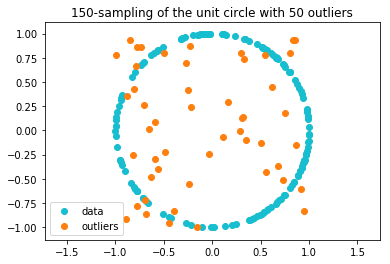

In [3]:
' Sampling on the circle with outlier '
N_obs = 150                                     # number of points sampled on the circle
N_out = 50                                      # number of outliers 
X = SampleOnCircle(N_obs, N_out, is_plot=True)  # sample points with outliers 

We first build the usual Rips filtration on this dataset.

Deprecated parameter. It has been replaced by max_intervals


Text(0.5,1,'Persistence diagram of the Rips complex')

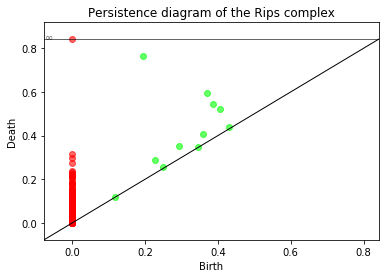

In [4]:
' Usual Rips complex on X '
st_rips = gudhi.RipsComplex(X).create_simplex_tree(max_dimension=2) # create a Rips complex     
diagram_rips = st_rips.persistence()                                # compute the persistence

# plot the persistence diagram
fig, ax = plt.subplots()
gudhi.plot_persistence_diagram(diagram_rips)                    
ax.set_title('Persistence diagram of the Rips complex')

On this diagram, 0-homology points are represented in red, and 1-homology in green.
Note that the 1-homology feature of the circle does not appear clearly here ($\beta_1 = 1$).

We now illustrate a DTM-filtration on $X$.
First, we compute the values of the DTM, with a given parameter $m \in [0,1)$. 

Text(0.5,1,'Values of the DTM on X with parameter m=0.1')

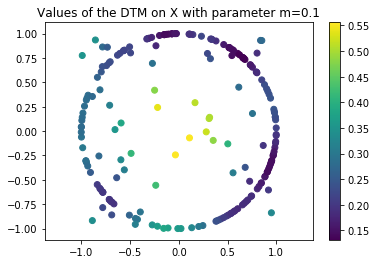

In [5]:
' Compute the DTM on X ' 
# compute the values of the DTM of parameter m
m = 0.1                            
DTM_values = DTM(X,X,m)             

# plot of the DTM
fig, ax = plt.subplots()
plot=ax.scatter(X[:,0], X[:,1], c=DTM_values)
fig.colorbar(plot)
ax.axis('equal')
ax.set_title('Values of the DTM on X with parameter m='+str(m))

Notice that the DTM takes greater values on the outliers.

We then build a DTM-filtration, and plot its persistence diagram. The filtration depends on a parameter $p \in [1, +\infty]$.

Weighted Rips Complex is of dimension 2 - 1333500 simplices - 200 vertices. Filtration maximal value is inf.
Deprecated parameter. It has been replaced by max_intervals


Text(0.5,1,'Persistence diagram of the DTM-filtration with parameter p =1')

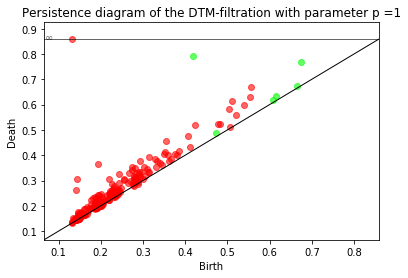

In [6]:
' Compute a DTM-filtration '
p = 1                                             
dimension_max = 2                               # maximal dimension to expand the complex
st_DTM = DTMFiltration(X, m, p, dimension_max)  # creating a simplex tree
diagram_DTM = st_DTM.persistence()              # compute the persistence diagram

# plot the persistence diagram
gudhi.plot_persistence_diagram(diagram_DTM)
plt.title('Persistence diagram of the DTM-filtration with parameter p ='+str(p))

Here, the 1-homology feature of the circle looks separated from the noise on the diagram (green point). The DTM-filtration is able to recognize the underlying circle.

We show below how greater values of $p$ tend to sparsify the persistence diagram.

Weighted Rips Complex is of dimension 2 - 1333500 simplices - 200 vertices. Filtration maximal value is inf.
Deprecated parameter. It has been replaced by max_intervals
Weighted Rips Complex is of dimension 2 - 1333500 simplices - 200 vertices. Filtration maximal value is inf.
Deprecated parameter. It has been replaced by max_intervals
Weighted Rips Complex is of dimension 2 - 1333500 simplices - 200 vertices. Filtration maximal value is inf.
Deprecated parameter. It has been replaced by max_intervals


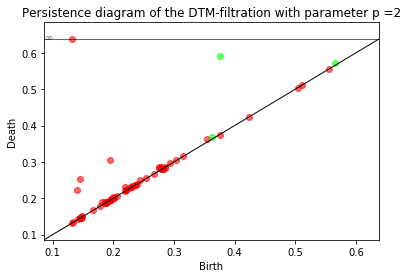

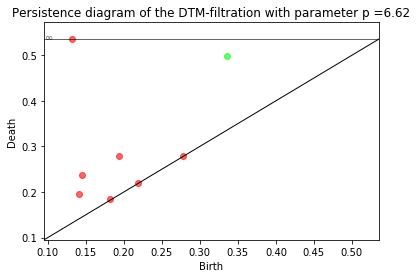

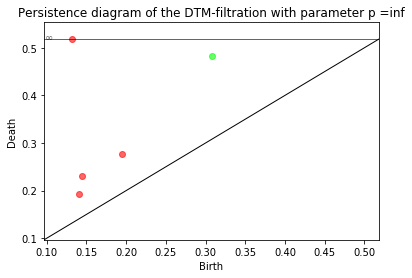

In [7]:
' DTM-filtrations for several values of p '
P = [2, 6.62, np.inf]

for p in P:
    st = DTMFiltration(X, m, p, dimension_max = 2)
    diagram = st.persistence()                  
    
    plt.figure()
    gudhi.plot_persistence_diagram(diagram)      
    plt.title('p ='+str(p))
    plt.title('Persistence diagram of the DTM-filtration with parameter p ='+str(p))

## Second dataset

We sample points on the union of a circle and three spheres in $\mathbb{R}^3$.

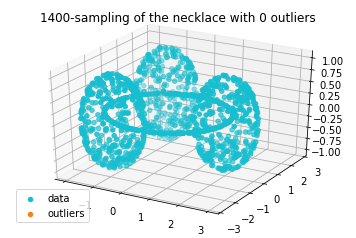

In [8]:
' Example with another dataset: necklace '
N_obs = 350                                           # number of points sampled on each component of the necklace
N_out = 0                                             # number of outliers 
X = SampleOnNecklace(N_obs, N_out, is_plot = True)

Instead of computing the Rips filtration on $X$, which contains 4*N_obs vertices, we build the alpha-complex, which contains less simplices.

Deprecated parameter. It has been replaced by max_intervals


Text(0.5,1,'Persistence diagram of the alpha-complex')

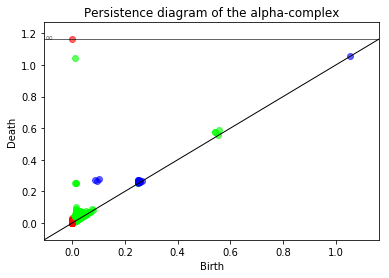

In [9]:
' Usual alpha-complex on X '
st_alpha = gudhi.AlphaComplex(points=X).create_simplex_tree()    # create an alpha-complex
diagram_alpha = st_alpha.persistence()                           # compute the persistence diagram

# plot the persistence diagram
plt.figure()
gudhi.plot_persistence_diagram(diagram_alpha)     #plot the persistence diagram
plt.title('Persistence diagram of the alpha-complex')

Blue points represent the 2-homology.
Between the values $t \in [0, 0.2]$ one can read the homology of the underlying object ($\beta_0 = 1$, $\beta_1 = 4$ and $\beta_2 = 3$).

We now build a DTM-filtration on $X$.
First, we illustrate how the value of the parameter $m$ can influence the DTM. Remind that, when the underlying measure admits a density on a $d$-dimensional submanifold $M$, there exists a constant $C>0$ such that the DTM on $M$ is not lower than $C m^\frac{1}{d}$.

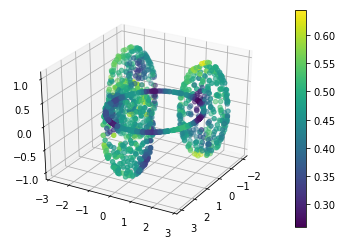

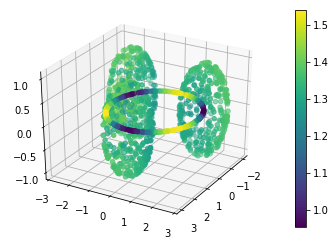

In [10]:
# DTM with parameter m = 0.03
m = 0.03
DTM_values = DTM(X,X,m)

fig = plt.figure(); 
ax = fig.gca(projection='3d')
plot = ax.scatter(X[:,0], X[:,1], X[:,2], c=DTM_values)
fig.colorbar(plot)
ax.view_init(30, 30)

# DTM with parameter m = 0.3
m = 0.3
DTM_values = DTM(X,X,m)

fig = plt.figure(); 
ax = fig.gca(projection='3d')
plot=ax.scatter(X[:,0], X[:,1], X[:,2], c=DTM_values)
fig.colorbar(plot)
ax.view_init(30, 30)

It appears that, for a small value of $m$, the DTM takes lower values on the circle than on the spheres, while for a greater value of $m$, the DTM takes high values where the circle is outside the spheres.

Since the number of points of $X$ is large, we use the function **AlphaDTMFiltration**.
This construction only is heuristic, but reduces the number of simplices drastically.
We start with the parameter $m = 0.03$.

Alpha Weighted Rips Complex is of dimension 3 - 59908 simplices - 1400 vertices. Filtration maximal value is inf.
Deprecated parameter. It has been replaced by max_intervals


Text(0.5,1,'Persistence diagram of the Alpha-DTM-filtration with parameter p =1')

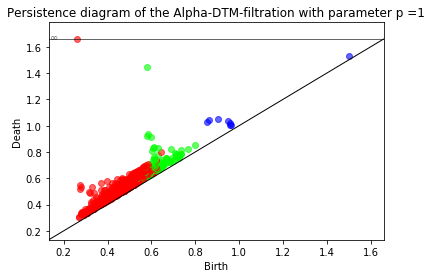

In [11]:
' Compute a DTM-filtration '
m = 0.03
p = 1
dimension_max = 3

# compute the persistence diagram
simplex_tree_DTM_alpha = AlphaDTMFiltration0(X, m, p, dimension_max)
diagram_DTM_alpha = simplex_tree_DTM_alpha.persistence()    

# plot the persistence diagram
plt.figure()
gudhi.plot_persistence_diagram(diagram_DTM_alpha)     
plt.title('Persistence diagram of the Alpha-DTM-filtration with parameter p ='+str(p))

One can still read the homology of $X$ on this diagram, for the values $t \in [0.8, 1.2]$ ($(\beta_0,\beta_1,\beta_2) = (1,4,2)$).

We now compute the DTM-filtration with the parameter $m = 0.3$.

Alpha Weighted Rips Complex is of dimension 3 - 59908 simplices - 1400 vertices. Filtration maximal value is inf.
Deprecated parameter. It has been replaced by max_intervals


Text(0.5,1,'Persistence diagram of the Alpha-DTM-filtration with parameter p=1')

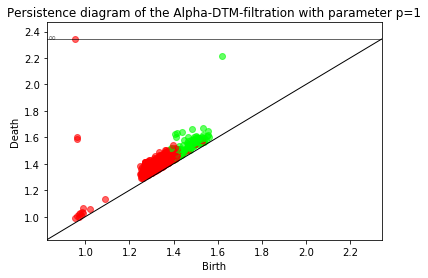

In [12]:
' Compute a DTM-filtration '
m = .3
p = 1
dimension_max = 3

# compute the persistence diagram
simplex_tree_DTM_alpha = AlphaDTMFiltration0(X, m, p, dimension_max)
diagram_DTM_alpha = simplex_tree_DTM_alpha.persistence()    

# plot the persistence diagram
plt.figure()
gudhi.plot_persistence_diagram(diagram_DTM_alpha)           
plt.title('Persistence diagram of the Alpha-DTM-filtration with parameter p='+str(p))

On this diagram, the homology of the spheres does not appear anymore, and one reads $(\beta_0,\beta_1,\beta_2) = (3,0,0)$ on the first part of the diagram, and $(\beta_0,\beta_1,\beta_2) = (1,1,0)$ on the second part.

Let us compare the DTM-filtrations for several values of $p$.

Alpha Weighted Rips Complex is of dimension 3 - 59908 simplices - 1400 vertices. Filtration maximal value is inf.
Deprecated parameter. It has been replaced by max_intervals
Alpha Weighted Rips Complex is of dimension 3 - 59908 simplices - 1400 vertices. Filtration maximal value is inf.
Deprecated parameter. It has been replaced by max_intervals
Alpha Weighted Rips Complex is of dimension 3 - 59908 simplices - 1400 vertices. Filtration maximal value is inf.
Deprecated parameter. It has been replaced by max_intervals


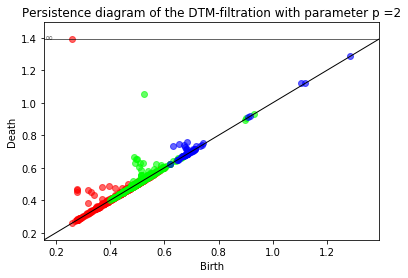

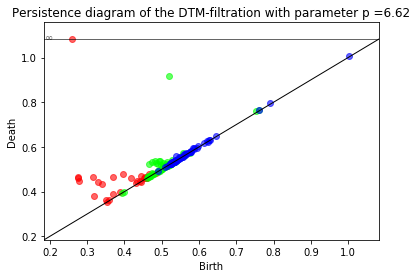

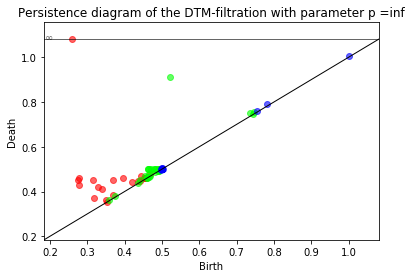

In [13]:
' DTM-filtrations for several values of p '
m = 0.03
P = [2, 6.62, np.inf]
dimension_max = 3

for p in P:
    st = AlphaDTMFiltration0(X, m, p, dimension_max)
    diagram = st.persistence()                  
    
    plt.figure()
    gudhi.plot_persistence_diagram(diagram)      
    plt.title('p ='+str(p))
    plt.title('Persistence diagram of the DTM-filtration with parameter p ='+str(p))

Notice that, for large values of $p$, the 2-homology of the underlying spheres does not appear clearly on the diagram. Information have been lost.

## Take-home message

Dependance of the DTM-filtration on its parameters:
-  higher values of $p$ tend to simplify the persistence diagram
-  the filtration is more stable for low values of $p$
-  different values of $m$ may highlight various areas of the dataset

This simple implementation can be used as follows:
``` 
# X is a nxd array
m = .1
p = 1                                            
dimension_max = 2     

simplex_tree = DTMFiltration(X, m, p, dimension_max) 
diagram = simplex_tree.persistence()
gudhi.plot_persistence_diagram(diagram)
```